In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from statsmodels.graphics import mosaicplot
import warnings
warnings.filterwarnings("ignore")

import pathlib
import sys

PROJECT_PATH = pathlib.Path.cwd()
SRC_PATH = PROJECT_PATH / "src"
sys.path.append(str(SRC_PATH))
from utils import cramers_v, compute_vif, likelihood_ratio_test, check_linearity

# Logistic Regression

Recall Model Equation:


$$
ln(\frac{\hat{p}}{1-\hat{p}}) = \beta_0 + \beta_1 x_1 + \beta_2 x_2... + \beta_kx_k
$$



If x is numeric, each unit increase in $x_1$ results in a $e^{\beta_1}$ increase in the odds of $y = 1$.

If x is categorical, then the increase in odds is $e^{\beta_1}$ times the odds of $y = 1$ if x = 1 compared to x = 0.

## Model Assumptions

1. Target variable is binary.

$$
Y \sim Binomial(n, p) \quad \epsilon \sim Binomial(0, np(1 - p)) 
$$

2. Linear Relation between X and log odds of y = 1. $(ln(\frac {\hat{p}}{1-\hat{p}}))$

3. $Y$ are independent.


## Dataset:

**low:** 1 if birth weight < 2500 g (low), 0 otherwise

**age:** mother’s age (years)

**lwt:** mother’s weight at last menstrual period (lbs)

**race** (1=white, 2=black, 3=other)

**smoke** (1=yes, 0=no)

**ptl:** number of previous premature labors

**ht:** hypertension history (1=yes, 0=no)

**ui:** uterine irritability (1=yes, 0=no)

**ftv:** number of first trimester doctor visits

**bwt:** birth weight (g)

In [2]:
url = "https://raw.githubusercontent.com/CEHS-research/data/master/Regression/lowbwt.txt"
df = pd.read_csv(url, sep="\s+").drop("id", axis=1)
df.head(3)

,low,age,lwt,race,smoke,ptl,ht,ui,ftv,bwt
0,0,19,182,2,0,0,0,1,0,2523
1,0,33,155,3,0,0,0,0,3,2551
2,0,20,105,1,1,0,0,0,1,2557


In [3]:
df.low.value_counts()

low
0    130
1     59
Name: count, dtype: int64

In [4]:
#check multicollinearity
vif_df = compute_vif(df)
vif_df

,feature,VIF
0,low,2.377654
1,age,18.540964
2,lwt,20.417113
3,race,5.082147
4,smoke,1.878673
5,ptl,1.324998
6,ht,1.220620
7,ui,1.290667
8,ftv,1.684994
9,bwt,21.632458


In [5]:
#drop bwt
df = df.drop("bwt",axis = 1)
vif_df = compute_vif(df)
vif_df


,feature,VIF
0,low,1.683036
1,age,14.670063
2,lwt,14.564177
3,race,4.622092
4,smoke,1.849882
5,ptl,1.323183
6,ht,1.187592
7,ui,1.280199
8,ftv,1.680125


<Axes: xlabel='age', ylabel='lwt'>

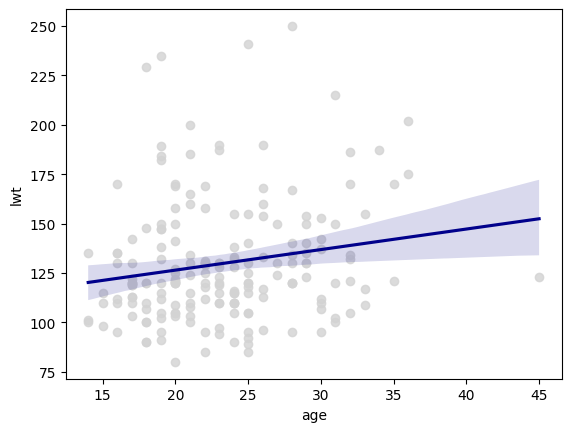

In [6]:
sns.regplot(x = "age", y = "lwt", data = df, line_kws={"color": "darkblue"}, scatter_kws={"color": "lightgrey"})

In [7]:
sake_of_discussion = smf.logit(formula = "low ~ smoke + age + C(race)", data = df).fit()
print(sake_of_discussion.summary())

Optimization terminated successfully.
         Current function value: 0.579001
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    low   No. Observations:                  189
Model:                          Logit   Df Residuals:                      184
Method:                           MLE   Df Model:                            4
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                 0.06737
Time:                        12:25:30   Log-Likelihood:                -109.43
converged:                       True   LL-Null:                       -117.34
Covariance Type:            nonrobust   LLR p-value:                  0.003285
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.0076      0.862     -1.169      0.242      -2.696       0.681
C(race)[T.2]     1.0114

* Model equation:

$$
\log\left(\frac{\hat{p}}{1 - \hat{p}}\right) =
-1.008 + 1.011 \cdot \text{race}_2 +
1.057 \cdot \text{race}_3 +
1.101 \cdot \text{smoke} -
0.035 \cdot \text{age}
$$

* Model is meaningful (LLR p-value <0.05).

* According to the model, `age` is not a significant variable (p-value > 0.05)

With each 1-year increase in age, the odds of low birth weight decrease by approximately **3%**  
  ($e^{-0.035} \approx 0.97$). (**Not statistically significant**)

Similarly, with each 5-year increase in age, the odds decrease by approximately **16%**  
  ($e^{-0.035 \times 5} \approx 0.84$). (**Not statistically significant**)

Smoking increases the odds of low birth weight by $e^{1.1} = (3.004 - 1) * 100 \approx 200\%$.

Being Black (compared to White; White is the reference category and therefore not explicitly shown in the model) increases the **odds** of low birth weight by approximately 175%, since $e^{1.01} \approx 2.75$.

Being other compared to white increases the **odds** of the low birth rate by 185\%, since $e^{1.05} \approx 2.85$.


## Likelihood Ratio Test (LRT)

LRT is used to compare two nested models.

$H_0:$ The full model and the reduced model are not statistically different.

$H_1:$ The full model and the reduced model are statistically different. Full model is better.


The LRT test statistic is given by:

$$
LR = -2 \left[ \log L_{\text{reduced}} - \log L_{\text{full}} \right] = 2 \left[ \log L_{\text{full}} - \log L_{\text{reduced}} \right]
$$

Where:

- $ \log L_{\text{full}}  $ = Log-likelihood of the full model  
-  $ \log L_{\text{reduced}} $ = Log-likelihood of the reduced model

This statistic approximately follows a  $ \chi^2  $ distribution with degrees of freedom equal to the number of additional parameters in the full model.


In [8]:
full_model = smf.logit(formula = "low ~ smoke + age + C(race) + lwt + ftv + ht", data = df).fit()
reduced_model = smf.logit(formula = "low ~ smoke + age + C(race) + lwt + ht", data = df).fit()

Optimization terminated successfully.
         Current function value: 0.549819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549941
         Iterations 6


In [9]:
test_stat, p_value = likelihood_ratio_test(full_model, reduced_model)

LR stat: 0.046, df diff: 1.0, p-value: 0.8304


p-value > 0.05. Therefore `fwt` can be dropped.

## Confounding

Are `race` and `smoke` confounding variables?

<Figure size 640x480 with 0 Axes>

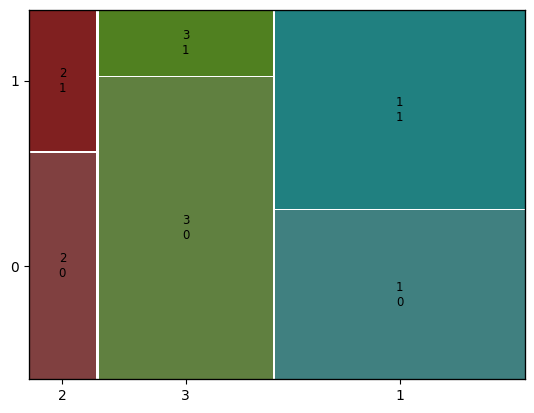

In [10]:
plt.figure()
mosaicplot.mosaic(df, ['race', 'smoke'])
plt.show()

From the plot, white people smoke more. This makes the `race` category a confounding variable. Let's check the relation between these two variables using Cramer's V:

In [11]:
cramers_v(df["race"], df["smoke"])

np.float64(0.33945972698574406)

Two variables are moderately correlated like we typically expect from confounding variables. Let's add them to our logistic model one by one.

In [12]:
model0 = smf.logit(formula = "low ~ smoke", data = df).fit()
print(model0.summary())

Optimization terminated successfully.
         Current function value: 0.607949
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    low   No. Observations:                  189
Model:                          Logit   Df Residuals:                      187
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                 0.02074
Time:                        12:25:30   Log-Likelihood:                -114.90
converged:                       True   LL-Null:                       -117.34
Covariance Type:            nonrobust   LLR p-value:                   0.02737
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0871      0.215     -5.062      0.000      -1.508      -0.666
smoke          0.7041      0.

In [13]:
model1 = smf.logit(formula = "low ~ smoke + C(race)", data = df).fit()
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.581944
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    low   No. Observations:                  189
Model:                          Logit   Df Residuals:                      185
Method:                           MLE   Df Model:                            3
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                 0.06263
Time:                        12:25:30   Log-Likelihood:                -109.99
converged:                       True   LL-Null:                       -117.34
Covariance Type:            nonrobust   LLR p-value:                  0.002094
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.8405      0.353     -5.216      0.000      -2.532      -1.149
C(race)[T.2]     1.0841

The standard error of `smoking` did not increased (inflated) significantly and model performance improved. Therefore, we are sure that `race` is a confounding variable.

## Model Comparison with AIC and BIC

AIC and BIC scores are used to compare two not necessarily nested models. They penalize the model complexity and reward model performance. Since our goal is to build the simplest model that predicts the outcome well, the model with the lowest AIC and BIC scores should be chosen. 

| ΔAIC | Model Explanation                                       |
| ---- | --------------------------------------------------- |
| 0–2  | Similar models there is no significant difference                   |
| 4–7  | Mid level difference – smaller one should be chosen   |
| >10  | High difference – smaller one needs to be chosen |


In [14]:
model1.aic - model0.aic

np.float64(-5.829888995849274)

`Model0` is more prefferable.

## Checking Linearity Assumptions

1. Divide data into 4 bins according to $x_i$ interested using quantiles.
2. Calculate the median of $x_i$ in each bin.
3. Calculate the mean of $y_i$ in each bin (it gives y=1 / all).
4. Plot the median of $x_i$ on the x-axis and the mean of $y_i$ on the y-axis.

If the line is not linear then the model assumption for $x_i$ is violated.

Possible solutions:

- Polynomial fit
- Binning
- Log transforms

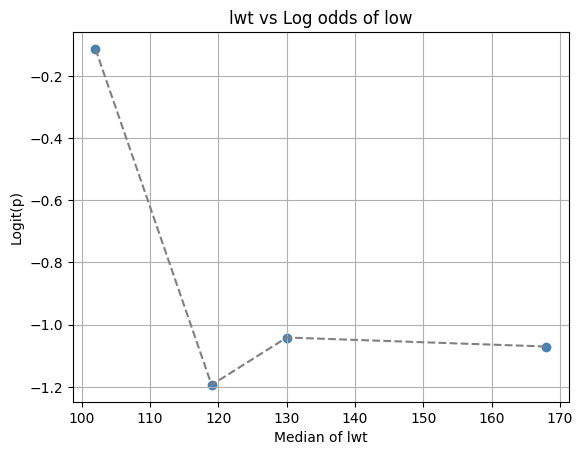

In [15]:
summary = check_linearity("lwt", "low", df)

when the weight is less than 110, then the probability of low birth weight is significantly higher whereas when the weight is greater than 110, the probability of low birth weight does not change much.

In [16]:
#df["lwt_cat"] = df["lwt"] < 110

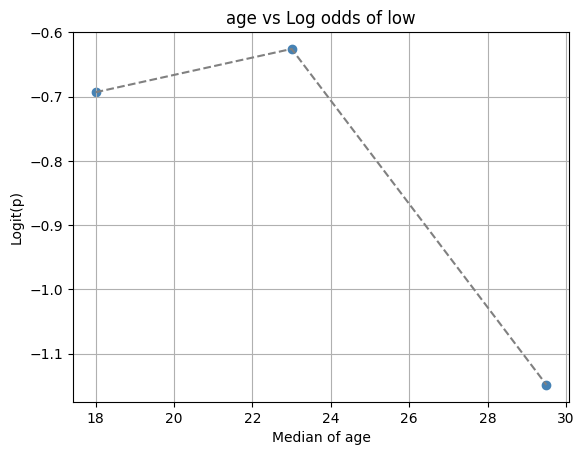

In [17]:
summary = check_linearity("age", "low", df, 3)

## Effect Size Model Selection

In [18]:
print(reduced_model.summary())

                           Logit Regression Results                           
Dep. Variable:                    low   No. Observations:                  189
Model:                          Logit   Df Residuals:                      182
Method:                           MLE   Df Model:                            6
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                  0.1142
Time:                        12:25:31   Log-Likelihood:                -103.94
converged:                       True   LL-Null:                       -117.34
Covariance Type:            nonrobust   LLR p-value:                 0.0001582
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7773      1.160      0.670      0.503      -1.497       3.052
C(race)[T.2]     1.2387      0.526      2.354      0.019       0.207       2.270
C(race)[T.3]     0.9191      0.427      2.15

In [19]:
reduced_model2 = smf.logit(formula = "low ~ smoke + C(race) + lwt + ht", data = df).fit()
print(reduced_model2.summary())

Optimization terminated successfully.
         Current function value: 0.550919
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    low   No. Observations:                  189
Model:                          Logit   Df Residuals:                      183
Method:                           MLE   Df Model:                            5
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                  0.1126
Time:                        12:25:31   Log-Likelihood:                -104.12
converged:                       True   LL-Null:                       -117.34
Covariance Type:            nonrobust   LLR p-value:                 7.381e-05
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3520      0.924      0.381      0.703      -1.460       2.164
C(race)[T.2]     1.2877

In [20]:
reduced_model2.aic - reduced_model.aic

np.float64(-1.6300954682983217)

we can drop `age` since delta aic < 2.

In [21]:
reduced_model3 = smf.logit(formula = "low ~ smoke + C(race) + ht", data = df).fit()
print(reduced_model3.summary())

Optimization terminated successfully.
         Current function value: 0.572355
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    low   No. Observations:                  189
Model:                          Logit   Df Residuals:                      184
Method:                           MLE   Df Model:                            4
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                 0.07807
Time:                        12:25:31   Log-Likelihood:                -108.18
converged:                       True   LL-Null:                       -117.34
Covariance Type:            nonrobust   LLR p-value:                  0.001068
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.9314      0.363     -5.324      0.000      -2.642      -1.220
C(race)[T.2]     1.0308

In [22]:
test_stat, p_value = likelihood_ratio_test(reduced_model2, reduced_model3)

LR stat: 8.103, df diff: 1.0, p-value: 0.0044


We can not drop `lwt` since likelihood ratio test indicates that `reduced_model2` is better.

In [23]:

reduced_model4 = smf.logit(formula = "low ~ smoke + C(race) + lwt + ht + ptl", data = df).fit()
print(reduced_model4.summary())

Optimization terminated successfully.
         Current function value: 0.542057
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    low   No. Observations:                  189
Model:                          Logit   Df Residuals:                      182
Method:                           MLE   Df Model:                            6
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                  0.1269
Time:                        12:25:31   Log-Likelihood:                -102.45
converged:                       True   LL-Null:                       -117.34
Covariance Type:            nonrobust   LLR p-value:                 4.339e-05
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1179      0.944      0.125      0.901      -1.733       1.968
C(race)[T.2]     1.2904

In [24]:
test_stat, p_value = likelihood_ratio_test(reduced_model4, reduced_model2)
print(reduced_model4.aic - reduced_model2.aic)

LR stat: 3.350, df diff: 1.0, p-value: 0.0672
-1.3497304031875785


Adding `ptl` does not improve the model.

In [25]:
reduced_model5 = smf.logit(formula = "low ~ smoke + C(race) + lwt + ht + ui", data = df).fit()
print(reduced_model5.summary())

Optimization terminated successfully.
         Current function value: 0.540256
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    low   No. Observations:                  189
Model:                          Logit   Df Residuals:                      182
Method:                           MLE   Df Model:                            6
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                  0.1298
Time:                        12:25:31   Log-Likelihood:                -102.11
converged:                       True   LL-Null:                       -117.34
Covariance Type:            nonrobust   LLR p-value:                 3.220e-05
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0563      0.938      0.060      0.952      -1.782       1.894
C(race)[T.2]     1.3246

In [26]:
test_stat, p_value = likelihood_ratio_test(reduced_model5, reduced_model2)
print(reduced_model5.aic - reduced_model2.aic)

LR stat: 4.031, df diff: 1.0, p-value: 0.0447
-2.030796196156558


In [27]:
reduced_model6 = smf.logit(formula = "low ~ smoke + C(race) + lwt + ht + smoke*lwt", data = df).fit()
print(reduced_model6.summary())
test_stat, p_value = likelihood_ratio_test(reduced_model6, reduced_model2)
print(reduced_model6.aic - reduced_model2.aic)

Optimization terminated successfully.
         Current function value: 0.549695
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    low   No. Observations:                  189
Model:                          Logit   Df Residuals:                      182
Method:                           MLE   Df Model:                            6
Date:                Wed, 09 Jul 2025   Pseudo R-squ.:                  0.1146
Time:                        12:25:31   Log-Likelihood:                -103.89
converged:                       True   LL-Null:                       -117.34
Covariance Type:            nonrobust   LLR p-value:                 0.0001520
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0102      1.368      0.738      0.460      -1.671       3.692
C(race)[T.2]     1.2871

Interaction term did not improved the model so we won't include it in our model.